In [1]:
import time
import os
import numpy as np
import torch
import torchvision.transforms as tv
from torchvision.utils import make_grid
from PIL import Image
from torchvision.transforms import Compose
import logging
import matplotlib.pyplot as plt
import pandas as pd
import glob
%matplotlib inline

In [2]:
'''Inference workflow 
 model = load_model(model_path) ->
 show_img_with_pred(image_path, model, show_results=1) | batch_prediction(images_folder_path, model, save_path='results.csv') '''

"Inference workflow \n model = load_model(model_path) ->\n show_img_with_pred(image_path, model, show_results=1) | batch_prediction(images_folder_path, model, save_path='results.csv') "

In [3]:
mylogs = logging.getLogger()
mylogs.setLevel(logging.INFO)
# Logging to file
file = logging.FileHandler("inference.log", mode='w')
file.setLevel(logging.INFO)
fileformat = logging.Formatter("%(asctime)s:%(levelname)s:%(message)s",datefmt="%H:%M:%S")
file.setFormatter(fileformat)
mylogs.addHandler(file)
# Logging to console
stream = logging.StreamHandler()
stream.setLevel(logging.INFO)
mylogs.addHandler(stream)
mylogs.info("Inference")

Inference


In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
mylogs.info(f"Device is: {str(device)}")

Device is: cuda


In [5]:
def load_model(model_path):
    ''' Loads a model and its state dict. Accepts path to the model, returns the model. Default cnn type is resnet18 '''
    saved_model = torch.load(f'{model_path}')
    model_name  = saved_model['model_name']
    categories = saved_model['сategories_data'][0]
    img_channels = saved_model['metadata']
    mylogs.info("Model: " + model_name)
    ###### fix it
    num_classes = len(categories)
    #########
    import resnet
    if model_name == 'ResNet18':
            model = resnet.ResNet18(img_channels, num_classes)
    elif model_name == 'ResNet34':
            model = resnet.ResNet34(img_channels, num_classes)
    elif model_name == 'ResNet50':
            model = resnet.ResNet50(img_channels, num_classes)
    elif model_name == 'ResNet101':
            model = resnet.ResNet101(img_channels, num_classes)
    elif model_name == 'ResNet152':
            model = resnet.ResNet152(img_channels, num_classes)
    else:
            model = resnet.ResNet18()    
    model.load_state_dict(torch.load(model_path)['model_state_dict'])
    model.eval()
    return model, categories, img_channels

In [6]:
def image_loader(image_path, img_channels):
    '''loads image,transforms it and returns  tensor'''
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img = transform(img_channels)(img)
    #As torch models expects a batch, this image should be turned into a batch with 1 image 
    img  = img.unsqueeze(0)
    return img.cpu() 

In [7]:
def show_img_with_pred(image_path, model, dimensions, show_results=1, n_pred=3):
    ''' Predicts one image, returns prediction '''
    img = image_loader(image_path,dimensions)
    img = img.to(device)
    model.to(device)
    with torch.no_grad():
        prediction = model(img)
        top_n_probs, top_n_labels = torch.topk(prediction, n_pred)
        softmax = torch.nn.Softmax(dim=1)
        
        top_n_prob_list = softmax(top_n_probs)[0].tolist()
        top_n_labels_list = top_n_labels[0].tolist()
        
    if show_results:
        img = img.to('cpu')
        model.to('cpu')
        figure, ax = plt.subplots(figsize=(6,6))
        predicted_labels = ""
        for n in range(n_pred):
            predicted_labels = predicted_labels + f"{categories[top_n_labels_list[n]]} : {round(top_n_prob_list[n],3)} \n "
        plt.title(f'Predicated label:\n {predicted_labels}', color= 'black')
        plt.imshow(make_grid(img,1).permute(1,2,0))
        plt.show()
    if not show_results:
        return prediction

In [8]:
def batch_prediction(images_folder_path, model,dimensions, save_path=None,n_pred = 3):
    ''' Make an inference on the images in the folder, returns a csv with results'''
    imgs_path_list = glob.glob(f'{images_folder_path}\*')
    mylogs.info(f"Inference started. \n {len(imgs_path_list)} images to predict")
    predictions = []
    names = []
    start_time = time.time()
    for image_path in imgs_path_list:
        names.append(os.path.split(image_path)[1])
        prediction = show_img_with_pred(image_path, model,dimensions, show_results=0)
        top_n_probs, top_n_labels = torch.topk(prediction, n_pred)
        softmax = torch.nn.Softmax(dim=1)
        
        top_n_prob_list = softmax(top_n_probs)[0].tolist()
        top_n_labels_list = top_n_labels[0].tolist()
        species_prob = []
        for label in top_n_labels_list:
            species = categories[label]
            species_prob.append(species)
        
        predictions.append(species_prob)
        
    df = pd.DataFrame({'Image' : pd.Series(names), 'Predictions' : pd.Series(predictions)})
    end_time = time.time()
    total_time = int(end_time - start_time)
    mylogs.info(f'Inference finished. Elapsed time: {total_time }s')
    if save_path:
        df.to_csv(save_path)
        mylogs.info(f'Results saved. Total time {round(total_time/60, 2)}')
    return df

In [9]:
model_path = "mri_classification_ResNet18_inference.pt"
model, categories, img_channels = load_model(model_path)

Model: ResNet18


In [10]:
if img_channels == 3:
    dimensions = ((0,0,0), (1,1,1))
elif img_channels == 1:
    dimensions = ((0), (1))

In [11]:
def transform(dimensions):
    return tv.Compose([
        tv.ToTensor(),
            tv.Normalize(dimensions[0],dimensions[1])
        ])

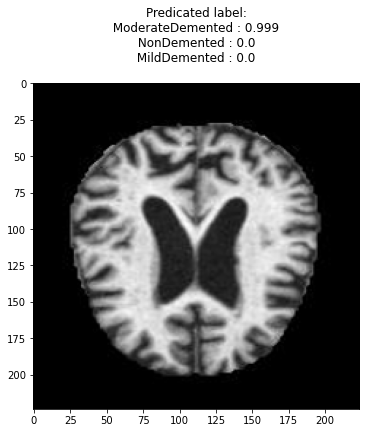

In [12]:
image_path = r'E:\mri\test\ModerateDemented\29 (2).jpg'
show_img_with_pred(image_path, model, dimensions, show_results=1)

In [13]:
images_folder_path = r'E:\mri\test_img'
df = batch_prediction(images_folder_path, model, dimensions, save_path='Results.csv')



Inference started. 
 668 images to predict
Inference finished. Elapsed time: 7s
Results saved. Total time 0.12
